# $$ Mini \space Project \space on \space Logistic \space Regression \space with \space a \space Neural \space Network \space  mindset $$ 
## $$  Building \space a \space Cat \space Classifier $$
### $$ By \space Debojjal \space Bagchi $$


## 1 - Packages ##

First, let's run the cell below to import all the packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from scipy import misc
import imageio
from lr_utils import load_dataset
from skimage.transform import resize
from skimage import data

%matplotlib inline

# 2 - Overview of the Problem ##

**Problem Statement**: Given a dataset ("data.h5") containing:
    - a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
    - a test set of m_test images labeled as cat or non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

We will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.


In [3]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

We added "_orig" at the end of image datasets (train and test) because we are going to preprocess them. After preprocessing, we will end up with train_set_x and test_set_x (the labels train_set_y and test_set_y don't need any preprocessing).


y = [1], it's a 'cat' picture.


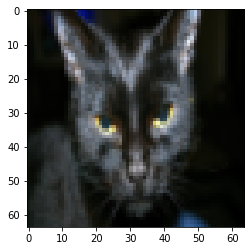

In [4]:
# Example of a picture
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")



Now, We will note down some details of the train and test data :

( **NOTE** - Remember that `train_set_x_orig` is a numpy-array of shape (m_train, num_px, num_px, 3). For instance, you can access `m_train` by writing `train_set_x_orig.shape[0]`. )

In [5]:
#Details
num_px = train_set_x_orig.shape[2]
print ("Number of training examples: m_train = " + str(train_set_x_orig.shape[0]))
print ("Number of testing examples: m_test = " + str(test_set_x_orig.shape[0]))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


<font color='blue'> 
    
For convenience, we will now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px $*$ num_px $*$ 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.

A trick when we will use to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b$*$c$*$d, a) is to use: 
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```

In [6]:
# Reshape the training and test examples

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T 

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


<font color='blue'>
    
To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize our dataset, meaning that we substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

Let's standardize our dataset.

In [7]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

## 3 - General Architecture of the learning algorithm ##

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
Now, we will carry out the following steps: 
    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude


## 4 - Building the parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

we will build 1-3 separately and integrate them into one function we call `model()`.


<font color='red'>

### 4.1 Sigmoid Function 

In [8]:
def sigmoid(z):
    
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    # start code:
    
    s = 1 / (1 + np.exp(-z))
    return s

    # end code :
    
    

<font color='red'>

### 4.2 - Initializing parameters

In [9]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    
    w = np.zeros((dim,1))
    b = 0
    
    return w, b

<font color='red'>

### 4.3 - Forward and Backward propagation

<font color='black'>
 
Now that your parameters are initialized, you can do the "forward" and "backward" propagation steps for learning the parameters.

Forward Propagation:
- Get X
- Compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- Calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas we will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [10]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    
    A = sigmoid(np.dot(w.T,X)+b)                                                         # compute activation
    cost = -1 / m * np.sum(Y*np.log(A)+(1-Y)*np.log(1-A), axis = 1, keepdims = True)     # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    
    dw = 1 / m * np.dot(X,(A-Y).T)
    db =  1 / m * np.sum(A-Y)
   
    cost = np.squeeze(cost)
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

<font color='red'>

### 4.4 - Optimization

<font color='black'>
We will to update the parameters using gradient descent.


In [11]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation 
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule 
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

<font color='red'>

### 5 - Prediction

The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X.Now we Implement the `predict()` function. There are two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`.

In [12]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        Y_prediction[0,i] = np.where(A[0,i]>0.5,1,0)
    
    return Y_prediction

<font color='red'>
    
## 5 - Merge all functions into a model ##

<font color='black'>
The overall model is now structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

In [13]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
   
    
    # initialize parameters with zeros 
    w, b =  initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples 
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d


<font color='red'>
    
## 6. Tweaking parameters while training `model()` 

<font color='brown'>

### 6.1) First we will try to find a good choice for alpha 

learning rate is: 0.01
train accuracy: 100.0 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 93.77990430622009 %
test accuracy: 74.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 73.6842105263158 %
test accuracy: 50.0 %

-------------------------------------------------------



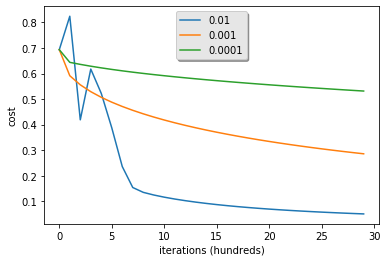

In [98]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 3000, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

<font color='green'>

Different learning rates give different costs and thus different predictions results.
    
- learning rate is too large for alpha = 0.01 as the cost oscillate up and down
- learning rate is too low for alpha = 0.0001, there is possibly overfitting.
- earning rate is too low for alpha = 0.001 seems right (although doesnt have lowest cost)

<font color='brown'>
    
#### Still I go for Alpha between $10^{-3}$ to $10^{-2}$ as it eventually doesnt diverge and has lowest cost

In [14]:
train_set_x.shape

(12288, 209)

In [24]:
train_set_y.shape

(1, 209)

In [56]:

from scipy.stats import boxcox


 # transform training data & save lambda value
train_data,fitted_lambda = boxcox(X_train['Age'])

# use lambda value to transform test data
test_data = boxcox(X_test['Age'], fitted_lambda)


In [95]:
alpha = np.arange(0.001, 0.02, 0.004)
for i in alpha : 
    print ("\n" + "learning rate is: " + str(i) + "\n")
    d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = i)
    


learning rate is: 0.001

train accuracy: 91.38755980861244 %
test accuracy: 68.0 %

learning rate is: 0.005

train accuracy: 99.04306220095694 %
test accuracy: 70.0 %

learning rate is: 0.009000000000000001

train accuracy: 99.52153110047847 %
test accuracy: 70.0 %

learning rate is: 0.013000000000000001

train accuracy: 100.0 %
test accuracy: 68.0 %

learning rate is: 0.017

train accuracy: 100.0 %
test accuracy: 68.0 %


<font color='brown'>

### alpha = 0.009 seems a good choice

In [97]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.009)

train accuracy: 99.52153110047847 %
test accuracy: 70.0 %


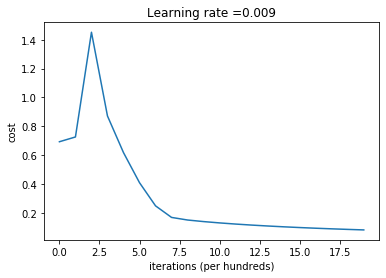

In [99]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

<font color='brown'>

### elbow itteration = 7500 (seems a good choice)

In [100]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 7500, learning_rate = 0.009)

train accuracy: 100.0 %
test accuracy: 70.0 %


<font color='red'>

## 7 -Test any image for Cat Claasificatiom
 
    1. Rename your image as test.jpeg
    2. Drag and drop your image in the images forlder 
    3. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!

In [108]:
my_image = "test.jpeg"   

# We preprocess the image to fit the algorithm.
fname = "images/" + my_image
image = np.array(imageio.imread(fname))
image = image/255.

my_image = resize(image, (num_px,num_px)).reshape((1, num_px*num_px*3)).T
image = data.camera()

my_predicted_image = predict(d["w"], d["b"], my_image)


print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")


y = 1.0, your algorithm predicts a "cat" picture.
